# Scoring v1 sobre Database-phishing.txt
**Ubicación:** notebooks/limpieza/phishing/phishing-database.ipynb

**Objetivo:** aplicar la versión 1 del scoring a `data/raw/Database-phishing.txt`, generar `data/processed/Database-phishing_scored.*`, analizar la distribución de scores, extraer muestras para revisión y dejar artefactos reproducibles (parquet, CSV, muestras de revisión manual).

**Notas importantes:**
- El notebook importa `scripts/apply_scoring_v1.py` (si lo tienes en `scripts/`). Si no, pega allí la función `score_url` o ejecuta la celda alternativa marcada.
- Añade `scoring_version` y `timestamp` para trazabilidad.
- Ejecuta en un entorno con pandas, tqdm, matplotlib; instala `rapidfuzz` si quieres mejor fuzzy matching.


In [28]:
import sys
# Imports principales
import os
import sys
import json
import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import scripts.scoring_v1
importlib.reload(scripts.scoring_v1)  # para forzar recarga si ya estaba cacheado




<module 'scripts.scoring_v1' from '/Users/test/Desktop/phishing-detector/scripts/scoring_v1.py'>

In [20]:

# Rutas (ajusta si tu repo está en otra raíz)
REPO_ROOT = Path(".").resolve().parents[0] if (Path(".") / ".git").exists() else Path(".").resolve()
sys.path.append(str(REPO_ROOT))
# Si ejecutas el notebook desde la carpeta notebooks/, hacer:
if Path.cwd().name == "notebooks":
    REPO_ROOT = Path.cwd().parents[0]

def detect_repo_root():
    """Detecta la raíz del proyecto buscando .git, README.md o carpeta scripts/"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / ".git").exists():
            return parent
        if (parent / "README.md").exists() and (parent / "scripts").exists():
            return parent
    raise RuntimeError("No se pudo detectar la raíz del proyecto. Asegúrate de estar dentro del repo.")

REPO_ROOT = detect_repo_root()
print("Raíz del proyecto:", REPO_ROOT)

Raíz del proyecto: /Users/test/Desktop/phishing-detector


In [31]:
DATA_RAW = REPO_ROOT / "data" / "raw" / "phishing"
DATA_PROCESSED = REPO_ROOT / "data" / "interim" / "phishing"
DATA_INTERIM = REPO_ROOT / "data" / "interim" / "phishing"
SCRIPTS_DIR = REPO_ROOT / "scripts"
NOTEBOOK_DIR = Path.cwd()
INPUT_FILE = DATA_RAW / "database-phishing.txt"
sys.path.append(str(SCRIPTS_DIR))


In [27]:
# Estás 3 niveles por debajo de la raíz del proyecto
REPO_ROOT = Path.cwd().parents[2]  # phishing-detector/
SCRIPTS_DIR = REPO_ROOT / "scripts"

# Añadir al sys.path
sys.path.append(str(REPO_ROOT))

print("REPO_ROOT:", REPO_ROOT)
print("SCRIPTS_DIR:", SCRIPTS_DIR)
print("scripts/ en sys.path:", SCRIPTS_DIR.exists())

REPO_ROOT: /Users/test/Desktop/phishing-detector
SCRIPTS_DIR: /Users/test/Desktop/phishing-detector/scripts
scripts/ en sys.path: True


In [33]:
from scripts.scoring_v1 import score_url_v1

# 1. Comprobar archivo
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"❌ No se encuentra el fichero en: {INPUT_FILE}")

# 2. Cargar URLs (preferiblemente con load_urls, si no, fallback)
if 'load_urls' in globals() and callable(load_urls):
    try:
        urls = list(load_urls(str(INPUT_FILE)))
        print(f"✅ {len(urls)} URLs cargadas con load_urls()")
    except Exception as e:
        print("⚠️ Error con load_urls, usando lectura manual:", e)
        with open(INPUT_FILE, "r", encoding="utf-8", errors="ignore") as f:
            urls = [line.strip() for line in f if line.strip()]
else:
    print("⚠️ load_urls() no disponible, usando lectura manual")
    with open(INPUT_FILE, "r", encoding="utf-8", errors="ignore") as f:
        urls = [line.strip() for line in f if line.strip()]

# 3. Mostrar primeras 5 URLs
print("\n🔎 Primeras 5 URLs cargadas:")
for i, u in enumerate(urls[:5], 1):
    print(f"{i}. {u}")

# 4. Cargar whitelist desde docs/spanish_domains.csv
whitelist_path = REPO_ROOT / "docs" / "spanish_domains.csv"
if not whitelist_path.exists():
    raise FileNotFoundError(f"❌ No se encuentra la whitelist en: {whitelist_path}")

df_whitelist = pd.read_csv(whitelist_path)
spanish_whitelist = df_whitelist["domain"].str.lower().tolist()

print(f"\n📥 Whitelist cargada con {len(spanish_whitelist)} dominios.")

# 5. Aplicar score_url_v1 a las primeras 10 URLs como test
print("\n⚙️ Aplicando score_url_v1() a las primeras 10 URLs...\n")
for i, u in enumerate(urls[:10], 1):
    try:
        score, signals = score_url_v1(u, spanish_whitelist)
        print(f"{i}. 🔗 {u}\n   🧮 Score: {score}\n   🧩 Señales: {signals}\n")
    except Exception as e:
        print(f"{i}. ❌ Error procesando URL: {u}\n   {e}\n")


⚠️ load_urls() no disponible, usando lectura manual

🔎 Primeras 5 URLs cargadas:
1. ftp://188.128.111.33/iptv/tv1324/view.html
2. ftp://me@createkindlebooks.org:noobasshole@createkindlebooks.org/index.html
3. http://00000000000000000000000000000000000000dfjjjhv.000webhostapp.com/yahoo/yahooattt/global/attverzon/login.php?.intl=us&.lang=en-us&https://login.yahoo.com/?.src=ym
4. http://000000000000000000000000000000000000dbscrfg.000webhostapp.com/yahoo/yahooattt/global/attverzon/login.php?https%3a//login.yahoo.com/?.src=ym&.intl=us&.lang=en-us
5. http://000000000000000000000000000yteyeuya.000webhostapp.com/yahoo/yahooattt/global/attverzon/login.php

📥 Whitelist cargada con 200 dominios.

⚙️ Aplicando score_url_v1() a las primeras 10 URLs...

1. 🔗 ftp://188.128.111.33/iptv/tv1324/view.html
   🧮 Score: 0
   🧩 Señales: 

2. 🔗 ftp://me@createkindlebooks.org:noobasshole@createkindlebooks.org/index.html
   🧮 Score: 0
   🧩 Señales: 

3. 🔗 http://00000000000000000000000000000000000000dfjjjhv.000

In [34]:
# ========== Nivel 2 – Scoring completo del dataset ==========

from tqdm import tqdm
import datetime

from scripts.scoring_v1 import score_url_v1

# 1. Cargar whitelist desde docs/
whitelist_path = REPO_ROOT / "docs" / "spanish_domains.csv"
df_whitelist = pd.read_csv(whitelist_path)
spanish_whitelist = df_whitelist["domain"].str.lower().tolist()
print(f"📥 Whitelist cargada con {len(spanish_whitelist)} dominios.\n")

# 2. Aplicar score_url_v1 a todas las URLs del dataset
results = []
print(f"🔍 Procesando {len(urls)} URLs...\n")

for u in tqdm(urls, desc="Scoring"):
    try:
        score, signals = score_url_v1(u, spanish_whitelist)
    except Exception as e:
        score, signals = None, f"error:{e}"
    results.append({
        "url": u,
        "score_total": score,
        "signals_detected": signals,
        "label_scored": int(score >= 2) if score is not None else None
    })

# 3. Convertir a DataFrame
df_scored = pd.DataFrame(results)
df_scored["timestamp"] = datetime.datetime.utcnow().isoformat()
df_scored["scoring_version"] = "v1"

# 4. Guardar en CSV y Parquet
out_csv = DATA_INTERIM / "database-phishing_scored.csv"
out_parquet = DATA_INTERIM / "database-phishing_scored.parquet"

df_scored.to_csv(out_csv, index=False)
df_scored.to_parquet(out_parquet, index=False)

print(f"✅ Guardado CSV en: {out_csv}")
print(f"✅ Guardado Parquet en: {out_parquet}")

# 5. Mostrar algunas filas
df_scored.head(10)


📥 Whitelist cargada con 200 dominios.

🔍 Procesando 1273433 URLs...



Scoring: 100%|██████████████████████| 1273433/1273433 [02:10<00:00, 9754.66it/s]


✅ Guardado CSV en: /Users/test/Desktop/phishing-detector/data/interim/phishing/database-phishing_scored.csv
✅ Guardado Parquet en: /Users/test/Desktop/phishing-detector/data/interim/phishing/database-phishing_scored.parquet


,url,score_total,signals_detected,label_scored,timestamp,scoring_version
0,ftp://188.128.111.33/iptv/tv1324/view.html,0,,0,2025-10-09T15:22:35.791764,v1
1,ftp://me@createkindlebooks.org:noobasshole@cre...,0,,0,2025-10-09T15:22:35.791764,v1
2,http://00000000000000000000000000000000000000d...,0,,0,2025-10-09T15:22:35.791764,v1
3,http://000000000000000000000000000000000000dbs...,0,,0,2025-10-09T15:22:35.791764,v1
4,http://000000000000000000000000000yteyeuya.000...,0,,0,2025-10-09T15:22:35.791764,v1
5,http://0000000000000000000000000.findyourjacke...,0,,0,2025-10-09T15:22:35.791764,v1
6,http://00000000000000000000000.fielty.mx,-2,latam_tld:.mx,0,2025-10-09T15:22:35.791764,v1
7,http://00000000000000000update.emy.ba,0,,0,2025-10-09T15:22:35.791764,v1
8,http://0000000000c0.x9xcax2a.workers.dev,0,,0,2025-10-09T15:22:35.791764,v1
9,http://000000000a0uutlook.weebly.com,0,,0,2025-10-09T15:22:35.791764,v1


In [35]:
# ========== Nivel 3 — Filtrar URLs con score > 2 ==========

# Si no has cargado el DataFrame, hazlo:
# df_scored = pd.read_parquet(DATA_INTERIM / "database-phishing_scored.parquet")

# Filtrar URLs con score alto
df_top = df_scored[df_scored["score_total"] > 2].copy()
print(f"🔎 Total de URLs con score > 2: {len(df_top)}")
print("\n🧪 Primeras 10:")

display(df_top[["url", "score_total", "signals_detected"]].head(10))


🔎 Total de URLs con score > 2: 76404

🧪 Primeras 10:


,url,score_total,signals_detected
27,http://000-845int283-000.xyz/directing/meridia...,3,spanish_brand:ing;brand_plus_spanish_token
30,http://000-845int283-000.xyz/directing/www.atb...,3,spanish_brand:ing;brand_plus_spanish_token
83,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
84,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
85,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
86,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
87,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
88,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
89,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...
90,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...


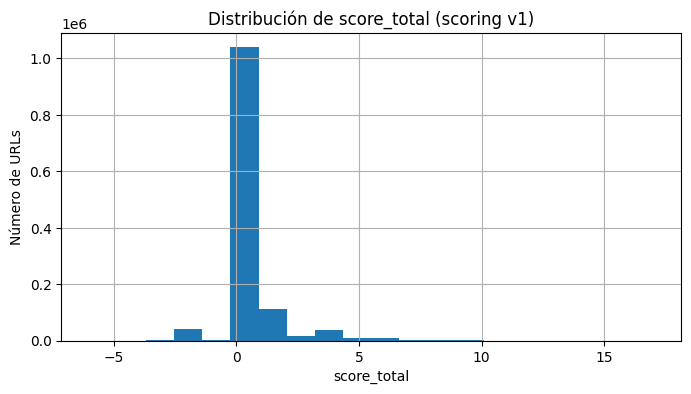

🔎 168878 de 1273433 URLs marcadas como orientadas a España (13.26%)

🧩 Top 15 señales más frecuentes entre score > 2:

spanish_brand:ing                   56642
brand_plus_spanish_token            49029
brand_global_tld_boost              48780
brand_in_subdomain                  35839
spanish_brand:dhl                    7200
spanish_brand:amazon                 6446
shortener_spain                      3329
fuzzy_whitelist_match:uco.es:80      2899
spanish_brand:orange                 2521
fuzzy_whitelist_match:amazon.es:80   2310
fuzzy_brand_match:amazon:80          2310
spanish_marker:.es                   1569
spanish_brand:evo                    1120
spanish_brand:santander              1101
spanish_brand:dgt                     593


In [36]:
from collections import Counter

# 1. Histograma de score_total
plt.figure(figsize=(8, 4))
df_scored["score_total"].hist(bins=20)
plt.title("Distribución de score_total (scoring v1)")
plt.xlabel("score_total")
plt.ylabel("Número de URLs")
plt.grid(True)
plt.show()

# 2. Proporción de URLs marcadas como españolas
prop = df_scored["label_scored"].mean()
total = len(df_scored)
print(f"🔎 {df_scored['label_scored'].sum()} de {total} URLs marcadas como orientadas a España ({prop:.2%})")

# 3. Señales más frecuentes entre los positivos
signals_all = ";".join(df_top["signals_detected"].dropna()).split(";")
counter = Counter(signals_all)
print("\n🧩 Top 15 señales más frecuentes entre score > 2:\n")
for k, v in counter.most_common(15):
    print(f"{k:<35} {v:>5}")

📊 Cantidad de URLs por nivel de score (> 2):



,n_urls
score_total,
3,16340
4,36667
5,10173
6,9443
7,2015
8,1240
9,249
10,45
11,114


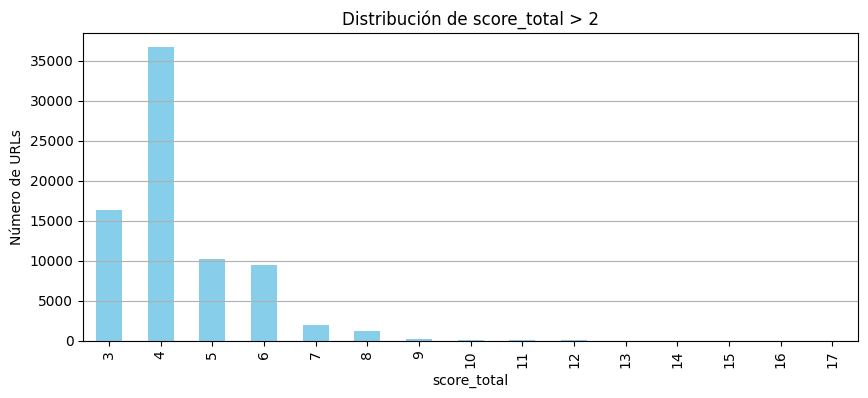

In [37]:
# ========== Nivel 3 – Conteo de niveles de score > 2 ==========

# Filtrar las URLs con score > 2
df_high = df_scored[df_scored["score_total"] > 2]

# Contar cuántas hay por cada score
score_counts = df_high["score_total"].value_counts().sort_index()

# Mostrar como tabla
print("📊 Cantidad de URLs por nivel de score (> 2):\n")
display(score_counts.to_frame(name="n_urls"))

# Mostrar como gráfico de barras
plt.figure(figsize=(10, 4))
score_counts.plot(kind="bar", color="skyblue")
plt.title("Distribución de score_total > 2")
plt.xlabel("score_total")
plt.ylabel("Número de URLs")
plt.grid(axis="y")
plt.show()


In [38]:
# ========== Nivel 4 – Muestra estratificada por score_total ==========

from pathlib import Path

# Rango de scores a muestrear
scores = list(range(3, 12))  # 3 a 11 inclusive
n_per_score = 20             # número de muestras por nivel
samples = []

# Crear la muestra estratificada
for s in scores:
    subset = df_scored[df_scored["score_total"] == s]
    if len(subset) >= n_per_score:
        sample = subset.sample(n_per_score, random_state=42)
    else:
        sample = subset  # coge todo lo que haya si hay menos
    sample["score_group"] = s
    samples.append(sample)

# Concatenar todo
df_stratified = pd.concat(samples).reset_index(drop=True)

# Guardar CSV para curación manual
sample_path = DATA_INTERIM / "sample_score_stratified.csv"
df_stratified.to_csv(sample_path, index=False, encoding="utf-8")

# Mostrar resumen
print(f"✅ Muestra estratificada creada con {len(df_stratified)} URLs.")
print(f"📄 Guardada en: {sample_path}")

# Vista previa
df_stratified[["url", "score_total", "signals_detected"]].head(10)


✅ Muestra estratificada creada con 180 URLs.
📄 Guardada en: /Users/test/Desktop/phishing-detector/data/interim/phishing/sample_score_stratified.csv


,url,score_total,signals_detected
0,https://wyowings.ch/wp-includes/simplepie/xms/...,3,spanish_brand:ing;brand_plus_spanish_token
1,http://pochtarefund-xeq165.aaknp.xyz/kampagnen...,3,spanish_brand:ing;brand_plus_spanish_token
2,http://alwaysbeautifulbilthoven.nl/support2fa/...,3,spanish_brand:ing;brand_plus_spanish_token
3,https://agitated-volhard.45-146-252-70.plesk.p...,3,spanish_brand:ing;brand_plus_spanish_token
4,https://trackingpaketdhl.com,3,spanish_brand:ing;spanish_brand:dhl;brand_glob...
5,https://mail.joingrupwhatsappnotnot.gift-event...,3,spanish_brand:ing;brand_in_subdomain
6,https://wvvw.amazon.co.jp-ae7ae9e176d1bfe838f8...,3,spanish_brand:amazon;brand_in_subdomain
7,https://agitated-volhard.45-146-252-70.plesk.p...,3,spanish_brand:ing;brand_plus_spanish_token
8,https://amazon.igbqxg.cn/signin/?openid_pape_m...,3,spanish_brand:amazon;brand_in_subdomain
9,https://www.whatsapevosmr05regi.truego00.ml,3,spanish_brand:evo;brand_in_subdomain


In [40]:
df_curacion[df_curacion["score_total"] >= 7]


,url,score_total,signals_detected,label_scored,timestamp,scoring_version,score_group,label_manual
80,https://foneworld-woking.co.uk/wp-includes/new...,7,spanish_brand:ing;fuzzy_whitelist_match:uco.es...,1,2025-10-09T15:22:35.791764,v1,7,None
81,https://apmrent.co.za/view.pictures.christianm...,7,spanish_brand:ing;fuzzy_whitelist_match:uco.es...,1,2025-10-09T15:22:35.791764,v1,7,None
82,http://page217112898915infringebusinessmistake...,7,spanish_brand:ing;fuzzy_whitelist_match:uco.es...,1,2025-10-09T15:22:35.791764,v1,7,None
83,https://foneworld-woking.co.uk/wp-includes/new...,7,spanish_brand:ing;fuzzy_whitelist_match:uco.es...,1,2025-10-09T15:22:35.791764,v1,7,None
84,http://reclamacionesorange.es,7,spanish_marker:.es;spanish_brand:orange;spanis...,1,2025-10-09T15:22:35.791764,v1,7,None
...,...,...,...,...,...,...,...,...
175,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...,1,2025-10-09T15:22:35.791764,v1,11,None
176,https://alderleamedical.com/sms/f1ba84040a0347...,11,spanish_marker:.es;spanish_brand:ing;banking_c...,1,2025-10-09T15:22:35.791764,v1,11,None
177,http://044088d.wcomhost.com/www.santanader.es/...,11,spanish_marker:.es;spanish_brand:santander;ban...,1,2025-10-09T15:22:35.791764,v1,11,None
178,https://correosprepago.bnext.es/register?from=...,11,has_kw:pago;spanish_marker:.es;spanish_brand:c...,1,2025-10-09T15:22:35.791764,v1,11,None


In [43]:
# ========== Guardar todo el primer dataset: primer_phishingrepo.csv ==========

# Filtrar todas las URLs con score >= 7
df_repo = df_scored[df_scored["score_total"] >= 10].copy()

# Añadir columnas si no existen
if "score_group" not in df_repo.columns:
    df_repo["score_group"] = df_repo["score_total"]

# Asignar label_manual = 1 (alto grado de confianza)
df_repo["label_manual"] = 1

# Guardar en CSV
output_path = DATA_INTERIM / "primer_phishingrepo.csv"
df_repo.to_csv(output_path, index=False, encoding="utf-8")

# Resumen
print(f"✅ Guardado {len(df_repo)} ejemplos en primer_phishingrepo.csv")
print(f"📄 Ruta: {output_path}")
df_repo[["url", "score_total", "signals_detected", "label_manual"]].head(5)


✅ Guardado 277 ejemplos en primer_phishingrepo.csv
📄 Ruta: /Users/test/Desktop/phishing-detector/data/interim/phishing/primer_phishingrepo.csv


,url,score_total,signals_detected,label_manual
83,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...,1
84,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...,1
85,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...,1
86,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...,1
87,http://000o8dc.wcomhost.com/www.santanderbanco...,11,spanish_marker:.es;spanish_brand:santander;ban...,1
